# Autoencoders in SciKeras

Autencoders are an approach to use nearual networks to distill data into it's most important features, thereby compressing the data. We will be following the [Keras tutorial](https://blog.keras.io/building-autoencoders-in-keras.html) on the topic, which goes much more in depth and breadth than we will here. You are highly encouraged to check out that tutorial if you want to learn about autoencoders in the general sense.

## Table of contents

* [1. Setup](#1.-Setup)
* [2. Data](#2.-Data)
* [3. Define Keras Model](#3.-Define-Keras-Model)
* [4. Training](#4.-Training)
* [5. Explore Results](#5.-Explore-Results)

## 1. Setup

In [1]:
try:
    import scikeras
except ImportError:
    !python -m pip install scikeras

Silence TensorFlow logging to keep output succinct.

In [2]:
import warnings
from tensorflow import get_logger
get_logger().setLevel('ERROR')
warnings.filterwarnings("ignore", message="Setting the random state for TF")

In [3]:
import numpy as np
from scikeras.wrappers import KerasClassifier, KerasRegressor
from tensorflow import keras

## 2. Data

We load the dataset from the Keras tutorial. The dataset consists of images of cats and dogs.

In [4]:
from tensorflow.keras.datasets import mnist
import numpy as np


(x_train, _), (x_test, _) = mnist.load_data()
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
print(x_train.shape)
print(x_test.shape)

    8192/11490434 [..............................] - ETA: 0s

 4202496/11490434 [=========>....................] - ETA: 0s

11493376/11490434 [==============================] - 0s 0us/step


(60000, 784)
(10000, 784)


## 3. Define Keras Model

We will be defining a very simple autencoder. We define _three_ model building methods:

1. One to build a full end-to-end autoencoder.
2. One to create a model that includes only the encoder portion.
3. One that creates a model that includes only the decoder portion.

The only variable we give our model is the encoding dimensions, which will be a hyperparemter of our final transformer.

In [5]:
from tensorflow import keras


def get_fit_model(encoding_dim: int) -> keras.Model:
    """Get an autoencoder.

    This autoencoder compresses a 28x28 image (784 pixels) down to a feature of length
    `encoding_dim`, and tries to reconstruct the input image from that vector.
    """
    input_img = keras.Input(shape=(784,), name="input")
    encoded = keras.layers.Dense(encoding_dim, activation='relu', name="encoded")(input_img)
    decoded = keras.layers.Dense(784, activation='sigmoid', name="output")(encoded)
    autoencoder_model = keras.Model(input_img, decoded)
    return autoencoder_model

def get_tf_model(fit_model: keras.Model) -> keras.Model:
    """Get an encoder model.

    We do this by extracting the encoding layer from the fitted autoencoder model.
    """
    return keras.Model(fit_model.get_layer("input").input, fit_model.get_layer("encoded").output)

def get_inverse_tf_model(fit_model: keras.Model, encoding_dim: int) -> keras.Model:
    """Get an deencoder model.

    We do this by extracting the deencoding layer from the fitted autoencoder model
    and adding a new Keras input layer.
    """
    encoded_input = keras.Input(shape=(encoding_dim,))
    output = fit_model.get_layer("output")(encoded_input)
    return keras.Model(encoded_input, output)

Next we create a class that that will enable the `transform` and `fit_transform` methods, as well as integrating all three of our models into a single estimator.

In [6]:
from sklearn.base import TransformerMixin, clone
from scikeras.wrappers import BaseWrapper


class KerasTransformer(BaseWrapper, TransformerMixin):
    """A class that enables transform and fit_transform.
    """

    def __init__(self, *args, tf_est: BaseWrapper = None, inv_tf_est: BaseWrapper = None, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.tf_est = tf_est
        self.inv_tf_est = inv_tf_est


    def fit(self, X, sample_weight=None):
        super().fit(X=X, y=X, sample_weight=sample_weight)
        self.tf_est_ = clone(self.tf_est)
        self.inv_tf_est_ = clone(self.inv_tf_est)
        self.tf_est_.set_params(fit_model=self.model_)
        self.inv_tf_est_.set_params(fit_model=self.model_, encoding_dim=self.encoding_dim)
        X = self.feature_encoder_.transform(X)
        self.tf_est_.initialize(X=X)
        X_tf = self.tf_est_.predict(X=X)
        self.inv_tf_est_.initialize(X_tf)
        return self

    def transform(self, X):
        X = self.feature_encoder_.transform(X)
        X_tf = self.tf_est_.predict(X)
        return X_tf
    
    def inverse_transform(self, X_tf):
        X = self.inv_tf_est_.predict(X_tf)
        X = self.feature_encoder_.inverse_transform(X)
        return X

Next, we wrap the Keras Model with Scikeras. Note that for our encoder/decoder estimators, we do not need to provide a loss function since no training will be done. We do however need to have the `fit_model` and `encoding_dim` so that these will be settable by `BaseWrapper.set_params`.

In [7]:
tf_est = BaseWrapper(model=get_tf_model, fit_model=None, verbose=0)
inv_tf_est = BaseWrapper(model=get_inverse_tf_model, fit_model=None, encoding_dim=None, verbose=0)
autoencoder = KerasTransformer(model=get_fit_model, tf_est=tf_est, inv_tf_est=inv_tf_est, loss="binary_crossentropy", encoding_dim=32, epochs=5)

## 4. Training

To train the model, we pass the input images as both the features and the target. This will train the layers to compress the data as accurately as possible between the encoder and decoder. Note that we only pass the `X` parameter, since we defined the mapping `y=X` in `KerasTransformer.fit` above.

In [8]:
_ = autoencoder.fit(X=x_train)

Epoch 1/5


   1/1875 [..............................] - ETA: 14:14 - loss: 0.6934

  24/1875 [..............................] - ETA: 4s - loss: 0.5705   

  54/1875 [..............................] - ETA: 3s - loss: 0.4753

  82/1875 [>.............................] - ETA: 3s - loss: 0.4307

 109/1875 [>.............................] - ETA: 3s - loss: 0.4033

 135/1875 [=>............................] - ETA: 3s - loss: 0.3840

 165/1875 [=>............................] - ETA: 3s - loss: 0.3668

 188/1875 [==>...........................] - ETA: 3s - loss: 0.3560

 210/1875 [==>...........................] - ETA: 3s - loss: 0.3470

 235/1875 [==>...........................] - ETA: 3s - loss: 0.3381

 259/1875 [===>..........................] - ETA: 3s - loss: 0.3305

 292/1875 [===>..........................] - ETA: 3s - loss: 0.3213

 319/1875 [====>.........................] - ETA: 2s - loss: 0.3147

 342/1875 [====>.........................] - ETA: 2s - loss: 0.3096

 367/1875 [====>.........................] - ETA: 2s - loss: 0.3045

 390/1875 [=====>........................] - ETA: 2s - loss: 0.3001

 410/1875 [=====>........................] - ETA: 2s - loss: 0.2965

 432/1875 [=====>........................] - ETA: 2s - loss: 0.2928

 454/1875 [======>.......................] - ETA: 2s - loss: 0.2893

 479/1875 [======>.......................] - ETA: 2s - loss: 0.2856

 501/1875 [=======>......................] - ETA: 2s - loss: 0.2825

 533/1875 [=======>......................] - ETA: 2s - loss: 0.2783

 558/1875 [=======>......................] - ETA: 2s - loss: 0.2752

 576/1875 [========>.....................] - ETA: 2s - loss: 0.2731

 606/1875 [========>.....................] - ETA: 2s - loss: 0.2698

 631/1875 [=========>....................] - ETA: 2s - loss: 0.2671

 656/1875 [=========>....................] - ETA: 2s - loss: 0.2646

 677/1875 [=========>....................] - ETA: 2s - loss: 0.2625

 706/1875 [==========>...................] - ETA: 2s - loss: 0.2598

 733/1875 [==========>...................] - ETA: 2s - loss: 0.2574

 756/1875 [===========>..................] - ETA: 2s - loss: 0.2555

 781/1875 [===========>..................] - ETA: 2s - loss: 0.2534

 803/1875 [===========>..................] - ETA: 2s - loss: 0.2517

 824/1875 [============>.................] - ETA: 2s - loss: 0.2501

 849/1875 [============>.................] - ETA: 2s - loss: 0.2482

 874/1875 [============>.................] - ETA: 2s - loss: 0.2464

 904/1875 [=============>................] - ETA: 1s - loss: 0.2443

 937/1875 [=============>................] - ETA: 1s - loss: 0.2421

 967/1875 [==============>...............] - ETA: 1s - loss: 0.2402

 997/1875 [==============>...............] - ETA: 1s - loss: 0.2384

1028/1875 [===============>..............] - ETA: 1s - loss: 0.2365

1058/1875 [===============>..............] - ETA: 1s - loss: 0.2348

1086/1875 [================>.............] - ETA: 1s - loss: 0.2333

1115/1875 [================>.............] - ETA: 1s - loss: 0.2317

1143/1875 [=================>............] - ETA: 1s - loss: 0.2303

1176/1875 [=================>............] - ETA: 1s - loss: 0.2286

1203/1875 [==================>...........] - ETA: 1s - loss: 0.2273

1235/1875 [==================>...........] - ETA: 1s - loss: 0.2257

1265/1875 [===================>..........] - ETA: 1s - loss: 0.2244

1299/1875 [===================>..........] - ETA: 1s - loss: 0.2228

1330/1875 [====================>.........] - ETA: 1s - loss: 0.2215

1359/1875 [====================>.........] - ETA: 0s - loss: 0.2203

1383/1875 [=====================>........] - ETA: 0s - loss: 0.2193

1410/1875 [=====================>........] - ETA: 0s - loss: 0.2182

1431/1875 [=====================>........] - ETA: 0s - loss: 0.2174

1459/1875 [======================>.......] - ETA: 0s - loss: 0.2163

1486/1875 [======================>.......] - ETA: 0s - loss: 0.2153

1512/1875 [=======================>......] - ETA: 0s - loss: 0.2143

1538/1875 [=======================>......] - ETA: 0s - loss: 0.2134

1565/1875 [========================>.....] - ETA: 0s - loss: 0.2124

1587/1875 [========================>.....] - ETA: 0s - loss: 0.2117

1616/1875 [========================>.....] - ETA: 0s - loss: 0.2107

1637/1875 [=========================>....] - ETA: 0s - loss: 0.2100

1658/1875 [=========================>....] - ETA: 0s - loss: 0.2093

1678/1875 [=========================>....] - ETA: 0s - loss: 0.2086

1704/1875 [==========================>...] - ETA: 0s - loss: 0.2078

1731/1875 [==========================>...] - ETA: 0s - loss: 0.2070

1756/1875 [===========================>..] - ETA: 0s - loss: 0.2062

1782/1875 [===========================>..] - ETA: 0s - loss: 0.2054

1807/1875 [===========================>..] - ETA: 0s - loss: 0.2047

1834/1875 [============================>.] - ETA: 0s - loss: 0.2039

1858/1875 [============================>.] - ETA: 0s - loss: 0.2032

1875/1875 [==============================] - 4s 2ms/step - loss: 0.2027


Epoch 2/5
   1/1875 [..............................] - ETA: 5s - loss: 0.1101

  27/1875 [..............................] - ETA: 3s - loss: 0.1098

  51/1875 [..............................] - ETA: 3s - loss: 0.1098

  77/1875 [>.............................] - ETA: 3s - loss: 0.1097

 101/1875 [>.............................] - ETA: 3s - loss: 0.1098

 125/1875 [=>............................] - ETA: 3s - loss: 0.1098

 150/1875 [=>............................] - ETA: 3s - loss: 0.1098

 177/1875 [=>............................] - ETA: 3s - loss: 0.1097

 200/1875 [==>...........................] - ETA: 3s - loss: 0.1097

 226/1875 [==>...........................] - ETA: 3s - loss: 0.1097

 251/1875 [===>..........................] - ETA: 3s - loss: 0.1096

 277/1875 [===>..........................] - ETA: 3s - loss: 0.1095

 300/1875 [===>..........................] - ETA: 3s - loss: 0.1095

 326/1875 [====>.........................] - ETA: 3s - loss: 0.1094

 350/1875 [====>.........................] - ETA: 3s - loss: 0.1094

 376/1875 [=====>........................] - ETA: 3s - loss: 0.1093

 401/1875 [=====>........................] - ETA: 3s - loss: 0.1092

 428/1875 [=====>........................] - ETA: 2s - loss: 0.1092

 451/1875 [======>.......................] - ETA: 2s - loss: 0.1091

 473/1875 [======>.......................] - ETA: 2s - loss: 0.1090

 498/1875 [======>.......................] - ETA: 2s - loss: 0.1089

 522/1875 [=======>......................] - ETA: 2s - loss: 0.1089

 543/1875 [=======>......................] - ETA: 2s - loss: 0.1088

 567/1875 [========>.....................] - ETA: 2s - loss: 0.1088

 590/1875 [========>.....................] - ETA: 2s - loss: 0.1087

 615/1875 [========>.....................] - ETA: 2s - loss: 0.1086

 635/1875 [=========>....................] - ETA: 2s - loss: 0.1086

 660/1875 [=========>....................] - ETA: 2s - loss: 0.1085

 686/1875 [=========>....................] - ETA: 2s - loss: 0.1085

 711/1875 [==========>...................] - ETA: 2s - loss: 0.1084

 729/1875 [==========>...................] - ETA: 2s - loss: 0.1084

 751/1875 [===========>..................] - ETA: 2s - loss: 0.1083

 773/1875 [===========>..................] - ETA: 2s - loss: 0.1083

 798/1875 [===========>..................] - ETA: 2s - loss: 0.1082

 825/1875 [============>.................] - ETA: 2s - loss: 0.1082

 853/1875 [============>.................] - ETA: 2s - loss: 0.1081

 880/1875 [=============>................] - ETA: 2s - loss: 0.1080

 910/1875 [=============>................] - ETA: 2s - loss: 0.1080

 937/1875 [=============>................] - ETA: 1s - loss: 0.1079

 965/1875 [==============>...............] - ETA: 1s - loss: 0.1079

 992/1875 [==============>...............] - ETA: 1s - loss: 0.1078

1020/1875 [===============>..............] - ETA: 1s - loss: 0.1077

1048/1875 [===============>..............] - ETA: 1s - loss: 0.1077

1068/1875 [================>.............] - ETA: 1s - loss: 0.1076

1092/1875 [================>.............] - ETA: 1s - loss: 0.1076

1120/1875 [================>.............] - ETA: 1s - loss: 0.1075

1148/1875 [=================>............] - ETA: 1s - loss: 0.1075

1175/1875 [=================>............] - ETA: 1s - loss: 0.1074

1200/1875 [==================>...........] - ETA: 1s - loss: 0.1074

1222/1875 [==================>...........] - ETA: 1s - loss: 0.1073

1248/1875 [==================>...........] - ETA: 1s - loss: 0.1073

1272/1875 [===================>..........] - ETA: 1s - loss: 0.1072

1298/1875 [===================>..........] - ETA: 1s - loss: 0.1072

1318/1875 [====================>.........] - ETA: 1s - loss: 0.1071

1342/1875 [====================>.........] - ETA: 1s - loss: 0.1071

1363/1875 [====================>.........] - ETA: 1s - loss: 0.1071

1385/1875 [=====================>........] - ETA: 1s - loss: 0.1070

1410/1875 [=====================>........] - ETA: 0s - loss: 0.1070

1433/1875 [=====================>........] - ETA: 0s - loss: 0.1069

1459/1875 [======================>.......] - ETA: 0s - loss: 0.1069

1489/1875 [======================>.......] - ETA: 0s - loss: 0.1068

1508/1875 [=======================>......] - ETA: 0s - loss: 0.1068

1519/1875 [=======================>......] - ETA: 0s - loss: 0.1068

1538/1875 [=======================>......] - ETA: 0s - loss: 0.1067

1559/1875 [=======================>......] - ETA: 0s - loss: 0.1067

1583/1875 [========================>.....] - ETA: 0s - loss: 0.1067

1607/1875 [========================>.....] - ETA: 0s - loss: 0.1066

1626/1875 [=========================>....] - ETA: 0s - loss: 0.1066

1646/1875 [=========================>....] - ETA: 0s - loss: 0.1066

1671/1875 [=========================>....] - ETA: 0s - loss: 0.1065

1690/1875 [==========================>...] - ETA: 0s - loss: 0.1065

1716/1875 [==========================>...] - ETA: 0s - loss: 0.1064

1744/1875 [==========================>...] - ETA: 0s - loss: 0.1064

1773/1875 [===========================>..] - ETA: 0s - loss: 0.1063

1798/1875 [===========================>..] - ETA: 0s - loss: 0.1063

1826/1875 [============================>.] - ETA: 0s - loss: 0.1063

1853/1875 [============================>.] - ETA: 0s - loss: 0.1062

1875/1875 [==============================] - 4s 2ms/step - loss: 0.1062


Epoch 3/5
   1/1875 [..............................] - ETA: 3s - loss: 0.0989

  25/1875 [..............................] - ETA: 3s - loss: 0.0995

  48/1875 [..............................] - ETA: 3s - loss: 0.0993

  70/1875 [>.............................] - ETA: 4s - loss: 0.0992

  93/1875 [>.............................] - ETA: 3s - loss: 0.0991

 117/1875 [>.............................] - ETA: 3s - loss: 0.0989

 143/1875 [=>............................] - ETA: 3s - loss: 0.0988

 167/1875 [=>............................] - ETA: 3s - loss: 0.0987

 191/1875 [==>...........................] - ETA: 3s - loss: 0.0987

 218/1875 [==>...........................] - ETA: 3s - loss: 0.0987

 245/1875 [==>...........................] - ETA: 3s - loss: 0.0986

 274/1875 [===>..........................] - ETA: 3s - loss: 0.0986

 297/1875 [===>..........................] - ETA: 3s - loss: 0.0985

 325/1875 [====>.........................] - ETA: 3s - loss: 0.0985

 350/1875 [====>.........................] - ETA: 3s - loss: 0.0985

 377/1875 [=====>........................] - ETA: 3s - loss: 0.0985

 405/1875 [=====>........................] - ETA: 2s - loss: 0.0985

 427/1875 [=====>........................] - ETA: 2s - loss: 0.0985

 452/1875 [======>.......................] - ETA: 2s - loss: 0.0984

 478/1875 [======>.......................] - ETA: 2s - loss: 0.0984

 504/1875 [=======>......................] - ETA: 2s - loss: 0.0984

 520/1875 [=======>......................] - ETA: 2s - loss: 0.0984

 544/1875 [=======>......................] - ETA: 2s - loss: 0.0984

 571/1875 [========>.....................] - ETA: 2s - loss: 0.0984

 599/1875 [========>.....................] - ETA: 2s - loss: 0.0984

 624/1875 [========>.....................] - ETA: 2s - loss: 0.0984

 649/1875 [=========>....................] - ETA: 2s - loss: 0.0984

 676/1875 [=========>....................] - ETA: 2s - loss: 0.0983

 704/1875 [==========>...................] - ETA: 2s - loss: 0.0983

 731/1875 [==========>...................] - ETA: 2s - loss: 0.0983

 759/1875 [===========>..................] - ETA: 2s - loss: 0.0983

 786/1875 [===========>..................] - ETA: 2s - loss: 0.0983

 813/1875 [============>.................] - ETA: 2s - loss: 0.0983

 841/1875 [============>.................] - ETA: 2s - loss: 0.0983

 866/1875 [============>.................] - ETA: 2s - loss: 0.0983

 893/1875 [=============>................] - ETA: 1s - loss: 0.0983

 920/1875 [=============>................] - ETA: 1s - loss: 0.0983

 949/1875 [==============>...............] - ETA: 1s - loss: 0.0982

 975/1875 [==============>...............] - ETA: 1s - loss: 0.0982

1004/1875 [===============>..............] - ETA: 1s - loss: 0.0982

1033/1875 [===============>..............] - ETA: 1s - loss: 0.0982

1062/1875 [===============>..............] - ETA: 1s - loss: 0.0982

1085/1875 [================>.............] - ETA: 1s - loss: 0.0982

1113/1875 [================>.............] - ETA: 1s - loss: 0.0982

1139/1875 [=================>............] - ETA: 1s - loss: 0.0982

1165/1875 [=================>............] - ETA: 1s - loss: 0.0982

1191/1875 [==================>...........] - ETA: 1s - loss: 0.0982

1211/1875 [==================>...........] - ETA: 1s - loss: 0.0982

1238/1875 [==================>...........] - ETA: 1s - loss: 0.0981

1266/1875 [===================>..........] - ETA: 1s - loss: 0.0981

1295/1875 [===================>..........] - ETA: 1s - loss: 0.0981

1323/1875 [====================>.........] - ETA: 1s - loss: 0.0981

1352/1875 [====================>.........] - ETA: 1s - loss: 0.0981

1378/1875 [=====================>........] - ETA: 0s - loss: 0.0981

1406/1875 [=====================>........] - ETA: 0s - loss: 0.0981

1432/1875 [=====================>........] - ETA: 0s - loss: 0.0981

1460/1875 [======================>.......] - ETA: 0s - loss: 0.0981

1485/1875 [======================>.......] - ETA: 0s - loss: 0.0981

1507/1875 [=======================>......] - ETA: 0s - loss: 0.0981

1533/1875 [=======================>......] - ETA: 0s - loss: 0.0980

1554/1875 [=======================>......] - ETA: 0s - loss: 0.0980

1581/1875 [========================>.....] - ETA: 0s - loss: 0.0980

1608/1875 [========================>.....] - ETA: 0s - loss: 0.0980

1635/1875 [=========================>....] - ETA: 0s - loss: 0.0980

1656/1875 [=========================>....] - ETA: 0s - loss: 0.0980

1678/1875 [=========================>....] - ETA: 0s - loss: 0.0980

1698/1875 [==========================>...] - ETA: 0s - loss: 0.0980

1720/1875 [==========================>...] - ETA: 0s - loss: 0.0980

1741/1875 [==========================>...] - ETA: 0s - loss: 0.0980

1766/1875 [===========================>..] - ETA: 0s - loss: 0.0980

1789/1875 [===========================>..] - ETA: 0s - loss: 0.0980

1815/1875 [============================>.] - ETA: 0s - loss: 0.0980

1833/1875 [============================>.] - ETA: 0s - loss: 0.0980

1857/1875 [============================>.] - ETA: 0s - loss: 0.0980

1875/1875 [==============================] - 4s 2ms/step - loss: 0.0979


Epoch 4/5
   1/1875 [..............................] - ETA: 4s - loss: 0.0927

  30/1875 [..............................] - ETA: 3s - loss: 0.0968

  58/1875 [..............................] - ETA: 3s - loss: 0.0967

  85/1875 [>.............................] - ETA: 3s - loss: 0.0964

 113/1875 [>.............................] - ETA: 3s - loss: 0.0963

 140/1875 [=>............................] - ETA: 3s - loss: 0.0963

 168/1875 [=>............................] - ETA: 3s - loss: 0.0963

 195/1875 [==>...........................] - ETA: 3s - loss: 0.0963

 224/1875 [==>...........................] - ETA: 3s - loss: 0.0963

 246/1875 [==>...........................] - ETA: 3s - loss: 0.0963

 269/1875 [===>..........................] - ETA: 3s - loss: 0.0963

 293/1875 [===>..........................] - ETA: 3s - loss: 0.0963

 318/1875 [====>.........................] - ETA: 3s - loss: 0.0963

 343/1875 [====>.........................] - ETA: 2s - loss: 0.0964

 368/1875 [====>.........................] - ETA: 2s - loss: 0.0964

 393/1875 [=====>........................] - ETA: 2s - loss: 0.0964

 418/1875 [=====>........................] - ETA: 2s - loss: 0.0964

 443/1875 [======>.......................] - ETA: 2s - loss: 0.0964

 468/1875 [======>.......................] - ETA: 2s - loss: 0.0964

 494/1875 [======>.......................] - ETA: 2s - loss: 0.0965

 521/1875 [=======>......................] - ETA: 2s - loss: 0.0965

 548/1875 [=======>......................] - ETA: 2s - loss: 0.0965

 572/1875 [========>.....................] - ETA: 2s - loss: 0.0965

 599/1875 [========>.....................] - ETA: 2s - loss: 0.0965

 623/1875 [========>.....................] - ETA: 2s - loss: 0.0965

 646/1875 [=========>....................] - ETA: 2s - loss: 0.0965

 670/1875 [=========>....................] - ETA: 2s - loss: 0.0965

 693/1875 [==========>...................] - ETA: 2s - loss: 0.0965

 716/1875 [==========>...................] - ETA: 2s - loss: 0.0965

 738/1875 [==========>...................] - ETA: 2s - loss: 0.0965

 758/1875 [===========>..................] - ETA: 2s - loss: 0.0965

 783/1875 [===========>..................] - ETA: 2s - loss: 0.0965

 810/1875 [===========>..................] - ETA: 2s - loss: 0.0965

 834/1875 [============>.................] - ETA: 2s - loss: 0.0965

 853/1875 [============>.................] - ETA: 2s - loss: 0.0965

 881/1875 [=============>................] - ETA: 2s - loss: 0.0965

 906/1875 [=============>................] - ETA: 1s - loss: 0.0965

 930/1875 [=============>................] - ETA: 1s - loss: 0.0965

 953/1875 [==============>...............] - ETA: 1s - loss: 0.0965

 976/1875 [==============>...............] - ETA: 1s - loss: 0.0965

1000/1875 [===============>..............] - ETA: 1s - loss: 0.0965

1025/1875 [===============>..............] - ETA: 1s - loss: 0.0965

1045/1875 [===============>..............] - ETA: 1s - loss: 0.0965

1067/1875 [================>.............] - ETA: 1s - loss: 0.0965

1089/1875 [================>.............] - ETA: 1s - loss: 0.0965

1105/1875 [================>.............] - ETA: 1s - loss: 0.0965

1131/1875 [=================>............] - ETA: 1s - loss: 0.0965

1154/1875 [=================>............] - ETA: 1s - loss: 0.0965

1177/1875 [=================>............] - ETA: 1s - loss: 0.0965

1200/1875 [==================>...........] - ETA: 1s - loss: 0.0965

1225/1875 [==================>...........] - ETA: 1s - loss: 0.0965

1247/1875 [==================>...........] - ETA: 1s - loss: 0.0965

1265/1875 [===================>..........] - ETA: 1s - loss: 0.0965

1291/1875 [===================>..........] - ETA: 1s - loss: 0.0965

1314/1875 [====================>.........] - ETA: 1s - loss: 0.0965

1339/1875 [====================>.........] - ETA: 1s - loss: 0.0965

1364/1875 [====================>.........] - ETA: 1s - loss: 0.0965

1391/1875 [=====================>........] - ETA: 1s - loss: 0.0965

1416/1875 [=====================>........] - ETA: 0s - loss: 0.0965

1442/1875 [======================>.......] - ETA: 0s - loss: 0.0965

1466/1875 [======================>.......] - ETA: 0s - loss: 0.0964

1492/1875 [======================>.......] - ETA: 0s - loss: 0.0964

1516/1875 [=======================>......] - ETA: 0s - loss: 0.0964

1542/1875 [=======================>......] - ETA: 0s - loss: 0.0964

1568/1875 [========================>.....] - ETA: 0s - loss: 0.0964

1594/1875 [========================>.....] - ETA: 0s - loss: 0.0964

1620/1875 [========================>.....] - ETA: 0s - loss: 0.0964

1644/1875 [=========================>....] - ETA: 0s - loss: 0.0964

1670/1875 [=========================>....] - ETA: 0s - loss: 0.0964

1697/1875 [==========================>...] - ETA: 0s - loss: 0.0964

1724/1875 [==========================>...] - ETA: 0s - loss: 0.0964

1749/1875 [==========================>...] - ETA: 0s - loss: 0.0964

1777/1875 [===========================>..] - ETA: 0s - loss: 0.0964

1798/1875 [===========================>..] - ETA: 0s - loss: 0.0964

1821/1875 [============================>.] - ETA: 0s - loss: 0.0964

1847/1875 [============================>.] - ETA: 0s - loss: 0.0964

1874/1875 [============================>.] - ETA: 0s - loss: 0.0964

1875/1875 [==============================] - 4s 2ms/step - loss: 0.0964


Epoch 5/5
   1/1875 [..............................] - ETA: 5s - loss: 0.0959

  22/1875 [..............................] - ETA: 4s - loss: 0.0948

  46/1875 [..............................] - ETA: 4s - loss: 0.0948

  70/1875 [>.............................] - ETA: 3s - loss: 0.0947

  92/1875 [>.............................] - ETA: 4s - loss: 0.0947

 114/1875 [>.............................] - ETA: 4s - loss: 0.0947

 144/1875 [=>............................] - ETA: 3s - loss: 0.0948

 169/1875 [=>............................] - ETA: 3s - loss: 0.0948

 188/1875 [==>...........................] - ETA: 3s - loss: 0.0949

 215/1875 [==>...........................] - ETA: 3s - loss: 0.0950

 238/1875 [==>...........................] - ETA: 3s - loss: 0.0950

 263/1875 [===>..........................] - ETA: 3s - loss: 0.0951

 284/1875 [===>..........................] - ETA: 3s - loss: 0.0951

 303/1875 [===>..........................] - ETA: 3s - loss: 0.0951

 325/1875 [====>.........................] - ETA: 3s - loss: 0.0951

 351/1875 [====>.........................] - ETA: 3s - loss: 0.0951

 371/1875 [====>.........................] - ETA: 3s - loss: 0.0952

 389/1875 [=====>........................] - ETA: 3s - loss: 0.0952

 412/1875 [=====>........................] - ETA: 3s - loss: 0.0952

 434/1875 [=====>........................] - ETA: 3s - loss: 0.0952

 459/1875 [======>.......................] - ETA: 3s - loss: 0.0952

 481/1875 [======>.......................] - ETA: 3s - loss: 0.0952

 506/1875 [=======>......................] - ETA: 3s - loss: 0.0952

 531/1875 [=======>......................] - ETA: 2s - loss: 0.0952

 552/1875 [=======>......................] - ETA: 2s - loss: 0.0952

 578/1875 [========>.....................] - ETA: 2s - loss: 0.0952

 602/1875 [========>.....................] - ETA: 2s - loss: 0.0952

 624/1875 [========>.....................] - ETA: 2s - loss: 0.0952

 645/1875 [=========>....................] - ETA: 2s - loss: 0.0952

 669/1875 [=========>....................] - ETA: 2s - loss: 0.0952

 693/1875 [==========>...................] - ETA: 2s - loss: 0.0952

 718/1875 [==========>...................] - ETA: 2s - loss: 0.0952

 741/1875 [==========>...................] - ETA: 2s - loss: 0.0952

 764/1875 [===========>..................] - ETA: 2s - loss: 0.0952

 788/1875 [===========>..................] - ETA: 2s - loss: 0.0952

 814/1875 [============>.................] - ETA: 2s - loss: 0.0952

 842/1875 [============>.................] - ETA: 2s - loss: 0.0952

 871/1875 [============>.................] - ETA: 2s - loss: 0.0952

 899/1875 [=============>................] - ETA: 2s - loss: 0.0953

 921/1875 [=============>................] - ETA: 2s - loss: 0.0953

 943/1875 [==============>...............] - ETA: 2s - loss: 0.0953

 963/1875 [==============>...............] - ETA: 1s - loss: 0.0953

 989/1875 [==============>...............] - ETA: 1s - loss: 0.0953

1012/1875 [===============>..............] - ETA: 1s - loss: 0.0953

1037/1875 [===============>..............] - ETA: 1s - loss: 0.0953

1059/1875 [===============>..............] - ETA: 1s - loss: 0.0953

1084/1875 [================>.............] - ETA: 1s - loss: 0.0953

1111/1875 [================>.............] - ETA: 1s - loss: 0.0953

1138/1875 [=================>............] - ETA: 1s - loss: 0.0953

1166/1875 [=================>............] - ETA: 1s - loss: 0.0953

1193/1875 [==================>...........] - ETA: 1s - loss: 0.0953

1219/1875 [==================>...........] - ETA: 1s - loss: 0.0953

1245/1875 [==================>...........] - ETA: 1s - loss: 0.0953

1272/1875 [===================>..........] - ETA: 1s - loss: 0.0953

1299/1875 [===================>..........] - ETA: 1s - loss: 0.0953

1325/1875 [====================>.........] - ETA: 1s - loss: 0.0953

1353/1875 [====================>.........] - ETA: 1s - loss: 0.0953

1380/1875 [=====================>........] - ETA: 1s - loss: 0.0953

1408/1875 [=====================>........] - ETA: 0s - loss: 0.0953

1434/1875 [=====================>........] - ETA: 0s - loss: 0.0953

1462/1875 [======================>.......] - ETA: 0s - loss: 0.0953

1489/1875 [======================>.......] - ETA: 0s - loss: 0.0953

1516/1875 [=======================>......] - ETA: 0s - loss: 0.0953

1544/1875 [=======================>......] - ETA: 0s - loss: 0.0953

1572/1875 [========================>.....] - ETA: 0s - loss: 0.0953

1599/1875 [========================>.....] - ETA: 0s - loss: 0.0953

1626/1875 [=========================>....] - ETA: 0s - loss: 0.0953

1654/1875 [=========================>....] - ETA: 0s - loss: 0.0953

1682/1875 [=========================>....] - ETA: 0s - loss: 0.0953

1710/1875 [==========================>...] - ETA: 0s - loss: 0.0953

1738/1875 [==========================>...] - ETA: 0s - loss: 0.0953

1767/1875 [===========================>..] - ETA: 0s - loss: 0.0953

1792/1875 [===========================>..] - ETA: 0s - loss: 0.0953

1819/1875 [============================>.] - ETA: 0s - loss: 0.0953

1846/1875 [============================>.] - ETA: 0s - loss: 0.0953

1872/1875 [============================>.] - ETA: 0s - loss: 0.0953

1875/1875 [==============================] - 4s 2ms/step - loss: 0.0953


Next, we round trip the test dataset and explore the performance of the autoencoder.

In [9]:
roundtrip_imgs = autoencoder.inverse_transform(autoencoder.transform(x_test))

## 5. Explore Results

Let's compare our inputs to lossy decoded outputs:

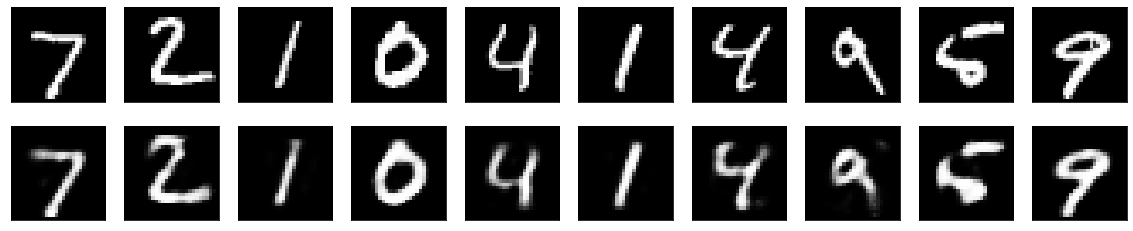

In [10]:
import matplotlib.pyplot as plt


n = 10  # How many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # Display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(roundtrip_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

What about the compression? Let's check the sizes of the arrays.

In [11]:
encoded_imgs = autoencoder.transform(x_test)
print(f"x_test.shape[1]: {x_test.shape[1]}")
print(f"encoded_imgs.shape[1]: {encoded_imgs.shape[1]}")
cr = round((encoded_imgs.nbytes/x_test.nbytes), 2)
print(f"Compression ratio: 1/{1/cr:.0f}")

x_test.shape[1]: 784
encoded_imgs.shape[1]: 32
Compression ratio: 1/25
